[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1OL7NeMHFuN-avzdnBkEm-n-0Sed8OPis?usp=share_link)

#Helper Function

In [1]:
import time
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from scipy.ndimage.interpolation import rotate as scipyrotate

import torch.optim as optim
import matplotlib.pyplot as plt
!pip install ptflops
from ptflops import get_model_complexity_info
import time

import tensorflow as tf
import random
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ptflops: filename=ptflops-0.6.9-py3-none-any.whl size=11712 sha256=d7f73ecdcd7179e16affd04b0320b3aed6396ea93ff5f2674dcb3dc17fada965
  Stored in directory: /root/.cache/pip/wheels/b6/86/d5/cf62a3571b005f91cd9accefc5e10f40214538be997198afad
Successfully built ptflops


In [2]:
''' Swish activation '''
class Swish(nn.Module): # Swish(x) = x∗σ(x)
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input * torch.sigmoid(input)


''' MLP '''
class MLP(nn.Module):
    def __init__(self, channel, num_classes):
        super(MLP, self).__init__()
        self.fc_1 = nn.Linear(28*28*1 if channel==1 else 32*32*3, 128)
        self.fc_2 = nn.Linear(128, 128)
        self.fc_3 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = F.relu(self.fc_1(out))
        out = F.relu(self.fc_2(out))
        out = self.fc_3(out)
        return out



''' ConvNet '''
class ConvNet(nn.Module):
    def __init__(self, channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size = (32,32)):
        super(ConvNet, self).__init__()

        self.features, shape_feat = self._make_layers(channel, net_width, net_depth, net_norm, net_act, net_pooling, im_size)
        num_feat = shape_feat[0]*shape_feat[1]*shape_feat[2]
        self.classifier = nn.Linear(num_feat, num_classes)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def embed(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        return out

    def _get_activation(self, net_act):
        if net_act == 'sigmoid':
            return nn.Sigmoid()
        elif net_act == 'relu':
            return nn.ReLU(inplace=True)
        elif net_act == 'leakyrelu':
            return nn.LeakyReLU(negative_slope=0.01)
        elif net_act == 'swish':
            return Swish()
        else:
            exit('unknown activation function: %s'%net_act)

    def _get_pooling(self, net_pooling):
        if net_pooling == 'maxpooling':
            return nn.MaxPool2d(kernel_size=2, stride=2)
        elif net_pooling == 'avgpooling':
            return nn.AvgPool2d(kernel_size=2, stride=2)
        elif net_pooling == 'none':
            return None
        else:
            exit('unknown net_pooling: %s'%net_pooling)

    def _get_normlayer(self, net_norm, shape_feat):
        # shape_feat = (c*h*w)
        if net_norm == 'batchnorm':
            return nn.BatchNorm2d(shape_feat[0], affine=True)
        elif net_norm == 'layernorm':
            return nn.LayerNorm(shape_feat, elementwise_affine=True)
        elif net_norm == 'instancenorm':
            return nn.GroupNorm(shape_feat[0], shape_feat[0], affine=True)
        elif net_norm == 'groupnorm':
            return nn.GroupNorm(4, shape_feat[0], affine=True)
        elif net_norm == 'none':
            return None
        else:
            exit('unknown net_norm: %s'%net_norm)

    def _make_layers(self, channel, net_width, net_depth, net_norm, net_act, net_pooling, im_size):
        layers = []
        in_channels = channel
        if im_size[0] == 28:
            im_size = (32, 32)
        shape_feat = [in_channels, im_size[0], im_size[1]]
        for d in range(net_depth):
            layers += [nn.Conv2d(in_channels, net_width, kernel_size=3, padding=3 if channel == 1 and d == 0 else 1)]
            shape_feat[0] = net_width
            if net_norm != 'none':
                layers += [self._get_normlayer(net_norm, shape_feat)]
            layers += [self._get_activation(net_act)]
            in_channels = net_width
            if net_pooling != 'none':
                layers += [self._get_pooling(net_pooling)]
                shape_feat[1] //= 2
                shape_feat[2] //= 2

        return nn.Sequential(*layers), shape_feat



''' LeNet '''
class LeNet(nn.Module):
    def __init__(self, channel, num_classes):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(channel, 6, kernel_size=5, padding=2 if channel==1 else 0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_1 = nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        return x



''' AlexNet '''
class AlexNet(nn.Module):
    def __init__(self, channel, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(channel, 128, kernel_size=5, stride=1, padding=4 if channel==1 else 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(192 * 4 * 4, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def embed(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x


''' AlexNetBN '''
class AlexNetBN(nn.Module):
    def __init__(self, channel, num_classes):
        super(AlexNetBN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(channel, 128, kernel_size=5, stride=1, padding=4 if channel==1 else 2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(192 * 4 * 4, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def embed(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x


''' VGG '''
cfg_vgg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}
class VGG(nn.Module):
    def __init__(self, vgg_name, channel, num_classes, norm='instancenorm'):
        super(VGG, self).__init__()
        self.channel = channel
        self.features = self._make_layers(cfg_vgg[vgg_name], norm)
        self.classifier = nn.Linear(512 if vgg_name != 'VGGS' else 128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def embed(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

    def _make_layers(self, cfg, norm):
        layers = []
        in_channels = self.channel
        for ic, x in enumerate(cfg):
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=3 if self.channel==1 and ic==0 else 1),
                           nn.GroupNorm(x, x, affine=True) if norm=='instancenorm' else nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def VGG11(channel, num_classes):
    return VGG('VGG11', channel, num_classes)
def VGG11BN(channel, num_classes):
    return VGG('VGG11', channel, num_classes, norm='batchnorm')
def VGG13(channel, num_classes):
    return VGG('VGG13', channel, num_classes)
def VGG16(channel, num_classes):
    return VGG('VGG16', channel, num_classes)
def VGG19(channel, num_classes):
    return VGG('VGG19', channel, num_classes)


''' ResNet_AP '''
# The conv(stride=2) is replaced by conv(stride=1) + avgpool(kernel_size=2, stride=2)

class BasicBlock_AP(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, norm='instancenorm'):
        super(BasicBlock_AP, self).__init__()
        self.norm = norm
        self.stride = stride
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False) # modification
        self.bn1 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=1, bias=False),
                nn.AvgPool2d(kernel_size=2, stride=2), # modification
                nn.GroupNorm(self.expansion * planes, self.expansion * planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        if self.stride != 1: # modification
            out = F.avg_pool2d(out, kernel_size=2, stride=2)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck_AP(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, norm='instancenorm'):
        super(Bottleneck_AP, self).__init__()
        self.norm = norm
        self.stride = stride
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False) # modification
        self.bn2 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.GroupNorm(self.expansion * planes, self.expansion * planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=1, bias=False),
                nn.AvgPool2d(kernel_size=2, stride=2),  # modification
                nn.GroupNorm(self.expansion * planes, self.expansion * planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        if self.stride != 1: # modification
            out = F.avg_pool2d(out, kernel_size=2, stride=2)
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_AP(nn.Module):
    def __init__(self, block, num_blocks, channel=3, num_classes=10, norm='instancenorm'):
        super(ResNet_AP, self).__init__()
        self.in_planes = 64
        self.norm = norm

        self.conv1 = nn.Conv2d(channel, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(64, 64, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.classifier = nn.Linear(512 * block.expansion * 3 * 3 if channel==1 else 512 * block.expansion * 4 * 4, num_classes)  # modification

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.norm))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, kernel_size=1, stride=1) # modification
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def embed(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, kernel_size=1, stride=1) # modification
        out = out.view(out.size(0), -1)
        return out

def ResNet18BN_AP(channel, num_classes):
    return ResNet_AP(BasicBlock_AP, [2,2,2,2], channel=channel, num_classes=num_classes, norm='batchnorm')

def ResNet18_AP(channel, num_classes):
    return ResNet_AP(BasicBlock_AP, [2,2,2,2], channel=channel, num_classes=num_classes)


''' ResNet '''

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, norm='instancenorm'):
        super(BasicBlock, self).__init__()
        self.norm = norm
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(self.expansion*planes, self.expansion*planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, norm='instancenorm'):
        super(Bottleneck, self).__init__()
        self.norm = norm
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.GroupNorm(self.expansion*planes, self.expansion*planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(self.expansion*planes, self.expansion*planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, channel=3, num_classes=10, norm='instancenorm'):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.norm = norm

        self.conv1 = nn.Conv2d(channel, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(64, 64, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.classifier = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.norm))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def embed(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return out


def ResNet18BN(channel, num_classes):
    return ResNet(BasicBlock, [2,2,2,2], channel=channel, num_classes=num_classes, norm='batchnorm')

def ResNet18(channel, num_classes):
    return ResNet(BasicBlock, [2,2,2,2], channel=channel, num_classes=num_classes)

def ResNet34(channel, num_classes):
    return ResNet(BasicBlock, [3,4,6,3], channel=channel, num_classes=num_classes)

def ResNet50(channel, num_classes):
    return ResNet(Bottleneck, [3,4,6,3], channel=channel, num_classes=num_classes)

def ResNet101(channel, num_classes):
    return ResNet(Bottleneck, [3,4,23,3], channel=channel, num_classes=num_classes)

def ResNet152(channel, num_classes):
    return ResNet(Bottleneck, [3,8,36,3], channel=channel, num_classes=num_classes)

def get_accuracy(model, data):
    correct = 0
    total = 0
    for imgs, labels in data:
        
        #############################################
        #To Enable GPU Usage
        #if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
        #############################################
        
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train_only(trainloader, model, batch_size, num_epochs, learning_rate):

    
    torch.manual_seed(100)


    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, test_acc = [], [], [], []
    start = time.time()
    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for image, label in iter(trainloader):
            #############################################
            #To Enable GPU Usage
            
            image = image.cuda()
            label = label.cuda()
            #############################################
            
              
            out = model(image)             # forward pass
            loss = criterion(out, label)       # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()           # a clean up step for PyTorch

            # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, trainloader)) # compute training accuracy 
        print("Epoch: ", n , '; train acc: ' ,train_acc[-1], '; train loss: ', float(loss))
        n += 1
    end = time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print('Training time: ', end - start)
    return model

def get_dataset(dataset, data_path):
    if dataset == 'MNIST':
        channel = 1
        im_size = (28, 28)
        num_classes = 10
        mean = [0.1307]
        std = [0.3081]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.MNIST(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
        class_names = [str(c) for c in range(num_classes)]

    elif dataset == 'CIFAR10':
        channel = 3
        im_size = (32, 32)
        num_classes = 10
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
        class_names = dst_train.classes

    elif dataset == 'FashionMNIST':
        channel = 1
        im_size = (28, 28)
        num_classes = 10
        mean = [0.2861]
        std = [0.3530]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transform)
        class_names = dst_train.classes


    testloader = torch.utils.data.DataLoader(dst_test, batch_size=256, shuffle=False, num_workers=0)
    return channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader

class TensorDataset(Dataset):
    def __init__(self, images, labels): # images: n x c x h x w tensor
        self.images = images.detach().float()
        self.labels = labels.detach()

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return self.images.shape[0]

def get_default_convnet_setting():
    net_width, net_depth, net_act, net_norm, net_pooling = 128, 3, 'relu', 'instancenorm', 'avgpooling'
    return net_width, net_depth, net_act, net_norm, net_pooling

def get_network(model, channel, num_classes, im_size=(32, 32)):
    torch.random.manual_seed(int(time.time() * 1000) % 100000)
    net_width, net_depth, net_act, net_norm, net_pooling = get_default_convnet_setting()

    if model == 'MLP':
        net = MLP(channel=channel, num_classes=num_classes)
    elif model == 'ConvNet':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'LeNet':
        net = LeNet(channel=channel, num_classes=num_classes)
    elif model == 'AlexNet':
        net = AlexNet(channel=channel, num_classes=num_classes)
    elif model == 'VGG11':
        net = VGG11( channel=channel, num_classes=num_classes)
    elif model == 'ResNet18':
        net = ResNet18(channel=channel, num_classes=num_classes)
    else:
        net = None
        exit('unknown model: %s'%model)

    gpu_num = torch.cuda.device_count()
    if gpu_num>0:
        device = 'cuda'
        if gpu_num>1:
            net = nn.DataParallel(net)
    else:
        device = 'cpu'
    net = net.to(device)

    return net

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#MNIST

In [ ]:
channel_mnist, im_size_mnist, num_classes_mnist, class_names_mnist, mean_mnist, std_mnist, dst_train_mnist, dst_test_mnist, testloader_mnist = get_dataset('MNIST', './../data')
# num_classes, dst_train, dst_test
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes_mnist)]

images_all = [torch.unsqueeze(dst_train_mnist[i][0], dim=0) for i in range(len(dst_train_mnist))]
labels_all = [dst_train_mnist[i][1] for i in range(len(dst_train_mnist))]
for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to('cuda')
labels_all = torch.tensor(labels_all, dtype=torch.long, device='cuda')
trainloader_mnist = torch.utils.data.DataLoader(TensorDataset(images_all, labels_all), batch_size=256, shuffle=True, num_workers=0)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./../data/MNIST/raw/train-images-idx3-ubyte.gz to ./../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./../data/MNIST/raw/train-labels-idx1-ubyte.gz to ./../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./../data/MNIST/raw



##Training from scratch

Epoch:  0 ; train acc:  0.983 ; train loss:  0.01932608149945736
Epoch:  1 ; train acc:  0.9889833333333333 ; train loss:  0.06797126680612564
Epoch:  2 ; train acc:  0.9909 ; train loss:  0.01671019196510315
Epoch:  3 ; train acc:  0.9932 ; train loss:  0.014124265871942043
Epoch:  4 ; train acc:  0.9941 ; train loss:  0.09530911594629288
Epoch:  5 ; train acc:  0.99415 ; train loss:  0.012990393675863743
Epoch:  6 ; train acc:  0.9934833333333334 ; train loss:  0.006301472429186106
Epoch:  7 ; train acc:  0.9963333333333333 ; train loss:  0.021409811452031136
Epoch:  8 ; train acc:  0.9962833333333333 ; train loss:  0.006075043696910143
Epoch:  9 ; train acc:  0.9965833333333334 ; train loss:  0.03358412906527519
Epoch:  10 ; train acc:  0.9956666666666667 ; train loss:  0.005996513646095991
Epoch:  11 ; train acc:  0.9980166666666667 ; train loss:  0.0059185088612139225
Epoch:  12 ; train acc:  0.9951 ; train loss:  0.0055039371363818645
Epoch:  13 ; train acc:  0.99815 ; train loss

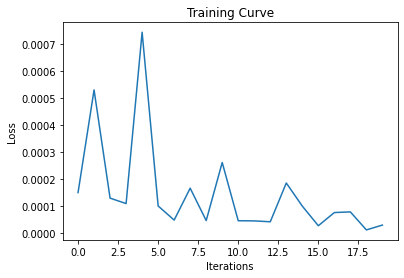

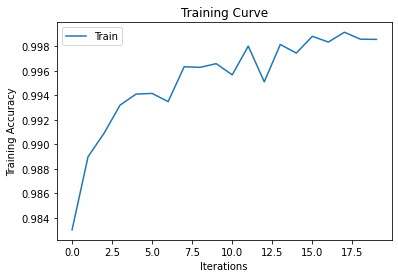

Final Training Accuracy: 0.9985666666666667
Training time:  202.30010080337524


In [ ]:
MNIST_Scratch = train_only(trainloader_mnist, get_network('ConvNet', channel_mnist, num_classes_mnist, im_size=im_size_mnist), batch_size=128, num_epochs=20, learning_rate=0.01)

In [ ]:
get_accuracy(MNIST_Scratch, testloader_mnist)

0.9937

##Training with Pre-Synthetic set online

In [ ]:
mnist_pre_syn_dict = torch.load('/content/drive/MyDrive/ECE1512/ProjectB/Pre-synthetic-set/res_DC_MNIST_ConvNet_10ipc.pt')
minst_pre_syn_data = tf.convert_to_tensor(mnist_pre_syn_dict['data'][0][0])
minst_pre_syn_label = tf.convert_to_tensor(mnist_pre_syn_dict['data'][0][1])
minst_pre_syn_data = torch.from_numpy(np.array(minst_pre_syn_data))
minst_pre_syn_label = torch.from_numpy(np.array(minst_pre_syn_label))
trainloader_mnist_pre_syn = torch.utils.data.DataLoader(TensorDataset(minst_pre_syn_data, minst_pre_syn_label), batch_size=256, shuffle=True, num_workers=0)

train group tensor(4)


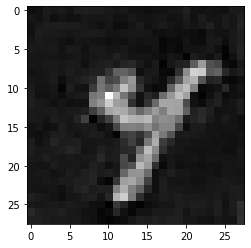

In [ ]:
index = random.randint(1, 99)
img=minst_pre_syn_data[index].reshape(im_size_mnist)
plt.imshow(img,cmap='gray')
print('train group',minst_pre_syn_label[index])

Epoch:  0 ; train acc:  0.21 ; train loss:  2.3224973678588867
Epoch:  1 ; train acc:  0.25 ; train loss:  2.241762638092041
Epoch:  2 ; train acc:  0.38 ; train loss:  2.1635055541992188
Epoch:  3 ; train acc:  0.71 ; train loss:  2.0617599487304688
Epoch:  4 ; train acc:  0.64 ; train loss:  1.9333207607269287
Epoch:  5 ; train acc:  0.55 ; train loss:  1.8227512836456299
Epoch:  6 ; train acc:  0.68 ; train loss:  1.7240474224090576
Epoch:  7 ; train acc:  0.81 ; train loss:  1.6092044115066528
Epoch:  8 ; train acc:  0.86 ; train loss:  1.5013115406036377
Epoch:  9 ; train acc:  0.91 ; train loss:  1.4046134948730469
Epoch:  10 ; train acc:  0.9 ; train loss:  1.3024617433547974
Epoch:  11 ; train acc:  0.89 ; train loss:  1.2004190683364868
Epoch:  12 ; train acc:  0.89 ; train loss:  1.1074953079223633
Epoch:  13 ; train acc:  0.95 ; train loss:  1.0199178457260132
Epoch:  14 ; train acc:  0.97 ; train loss:  0.9324324727058411
Epoch:  15 ; train acc:  1.0 ; train loss:  0.849311

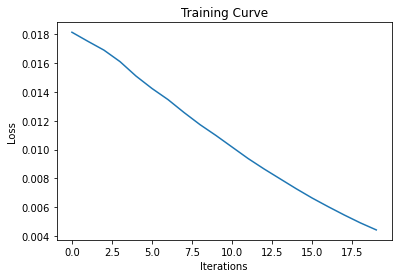

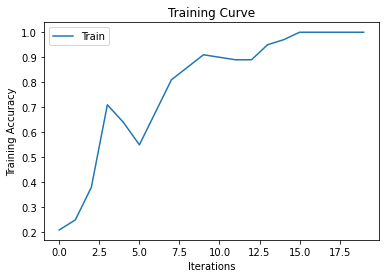

Final Training Accuracy: 1.0
Training time:  0.45662355422973633


In [ ]:
MNIST_pre_syn = train_only(trainloader_mnist_pre_syn, get_network('ConvNet', channel_mnist, num_classes_mnist, im_size=im_size_mnist), batch_size=128, num_epochs=20, learning_rate=0.01)

In [ ]:
get_accuracy(MNIST_pre_syn, testloader_mnist)

0.9211

##Training with generated synthetic set

In [ ]:
mnist_syn_dict = torch.load('/content/drive/MyDrive/ECE1512/ProjectB/All_Code/result/1000iterMNIST/res_DC_MNIST_LeNet_10ipc.pt')
minst_syn_data = tf.convert_to_tensor(mnist_syn_dict['data'][0][0])
minst_syn_label = tf.convert_to_tensor(mnist_syn_dict['data'][0][1])
minst_syn_data = torch.from_numpy(np.array(minst_syn_data))
minst_syn_label = torch.from_numpy(np.array(minst_syn_label))
trainloader_mnist_syn = torch.utils.data.DataLoader(TensorDataset(minst_syn_data, minst_syn_label), batch_size=256, shuffle=True, num_workers=0)

train group tensor(3)


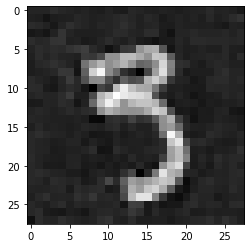

In [ ]:
index = random.randint(1, 99)
img=minst_pre_syn_data[index].reshape(im_size_mnist)
plt.imshow(img,cmap='gray')
print('train group',minst_pre_syn_label[index])

Epoch:  0 ; train acc:  0.12 ; train loss:  2.3309824466705322
Epoch:  1 ; train acc:  0.3 ; train loss:  2.25457501411438
Epoch:  2 ; train acc:  0.34 ; train loss:  2.177600622177124
Epoch:  3 ; train acc:  0.48 ; train loss:  2.0888044834136963
Epoch:  4 ; train acc:  0.65 ; train loss:  1.965416431427002
Epoch:  5 ; train acc:  0.61 ; train loss:  1.852613925933838
Epoch:  6 ; train acc:  0.69 ; train loss:  1.7601640224456787
Epoch:  7 ; train acc:  0.79 ; train loss:  1.653932809829712
Epoch:  8 ; train acc:  0.75 ; train loss:  1.541916012763977
Epoch:  9 ; train acc:  0.76 ; train loss:  1.448082685470581
Epoch:  10 ; train acc:  0.88 ; train loss:  1.3569639921188354
Epoch:  11 ; train acc:  0.86 ; train loss:  1.2581666707992554
Epoch:  12 ; train acc:  0.86 ; train loss:  1.167656421661377
Epoch:  13 ; train acc:  0.89 ; train loss:  1.0845569372177124
Epoch:  14 ; train acc:  0.93 ; train loss:  0.9986870288848877
Epoch:  15 ; train acc:  0.94 ; train loss:  0.9150496721267

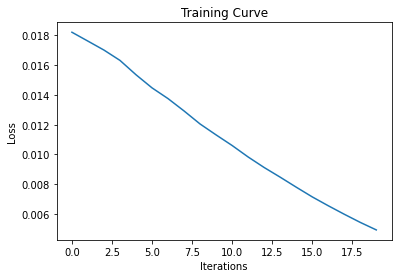

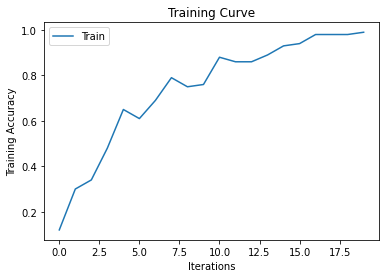

Final Training Accuracy: 0.99
Training time:  0.4583628177642822


In [ ]:
MNIST_syn = train_only(trainloader_mnist_pre_syn, get_network('ConvNet', channel_mnist, num_classes_mnist, im_size=im_size_mnist), batch_size=128, num_epochs=20, learning_rate=0.01)

In [ ]:
get_accuracy(MNIST_syn, testloader_mnist)

0.9078

#FashionMNIST

##Train from Scratch

In [4]:
channel_fashon, im_size_fashon, num_classes_fashon, class_names_fashon, mean_fashon, std_fashon, dst_train_fashon, dst_test_fashon, testloader_fashon = get_dataset('FashionMNIST', './../data')
# num_classes, dst_train, dst_test
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes_fashon)]

images_all = [torch.unsqueeze(dst_train_fashon[i][0], dim=0) for i in range(len(dst_train_fashon))]
labels_all = [dst_train_fashon[i][1] for i in range(len(dst_train_fashon))]
for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to('cuda')
labels_all = torch.tensor(labels_all, dtype=torch.long, device='cuda')
trainloader_fashon = torch.utils.data.DataLoader(TensorDataset(images_all, labels_all), batch_size=256, shuffle=True, num_workers=0)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./../data/FashionMNIST/raw



Epoch:  0 ; train acc:  0.8856666666666667 ; train loss:  0.5924003720283508
Epoch:  1 ; train acc:  0.9023833333333333 ; train loss:  0.36746683716773987
Epoch:  2 ; train acc:  0.9168666666666667 ; train loss:  0.2500613331794739
Epoch:  3 ; train acc:  0.91475 ; train loss:  0.21370966732501984
Epoch:  4 ; train acc:  0.9270833333333334 ; train loss:  0.20443743467330933
Epoch:  5 ; train acc:  0.93165 ; train loss:  0.30970966815948486
Epoch:  6 ; train acc:  0.9341333333333334 ; train loss:  0.2741040885448456
Epoch:  7 ; train acc:  0.9397666666666666 ; train loss:  0.23508203029632568
Epoch:  8 ; train acc:  0.9428 ; train loss:  0.0549912191927433
Epoch:  9 ; train acc:  0.9520333333333333 ; train loss:  0.20702695846557617
Epoch:  10 ; train acc:  0.9491166666666667 ; train loss:  0.13501940667629242
Epoch:  11 ; train acc:  0.9504 ; train loss:  0.16181133687496185
Epoch:  12 ; train acc:  0.944 ; train loss:  0.1723746657371521
Epoch:  13 ; train acc:  0.9581666666666667 ; t

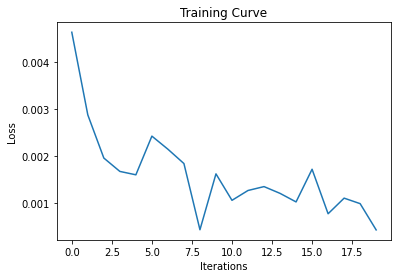

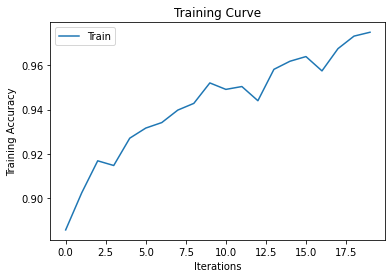

Final Training Accuracy: 0.9749166666666667
Training time:  199.68305230140686


In [ ]:
fashon_Scratch = train_only(trainloader_fashon, get_network('ConvNet', channel_fashon, num_classes_fashon, im_size=im_size_fashon), batch_size=128, num_epochs=20, learning_rate=0.01)

In [ ]:
get_accuracy(fashon_Scratch, testloader_fashon)

0.9318

##Train with Pre-Synthetic set online

In [ ]:
fashon_pre_syn_dict = torch.load('/content/drive/MyDrive/ECE1512/ProjectB/Pre-synthetic-set/res_DC_FashionMNIST_ConvNet_10ipc.pt')
fashon_pre_syn_data = tf.convert_to_tensor(fashon_pre_syn_dict['data'][0][0])
fashon_pre_syn_label = tf.convert_to_tensor(fashon_pre_syn_dict['data'][0][1])
fashon_pre_syn_data = torch.from_numpy(np.array(fashon_pre_syn_data))
fashon_pre_syn_label = torch.from_numpy(np.array(fashon_pre_syn_label))
trainloader_fashon_pre_syn = torch.utils.data.DataLoader(TensorDataset(fashon_pre_syn_data, fashon_pre_syn_label), batch_size=256, shuffle=True, num_workers=0)

train group tensor(9)


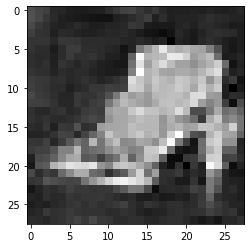

In [ ]:
index = random.randint(1, 99)
img=fashon_pre_syn_data[index].reshape(im_size_fashon)
plt.imshow(img,cmap='gray')
print('train group',fashon_pre_syn_label[index])

Epoch:  0 ; train acc:  0.28 ; train loss:  2.3890318870544434
Epoch:  1 ; train acc:  0.4 ; train loss:  2.1745004653930664
Epoch:  2 ; train acc:  0.47 ; train loss:  1.928514003753662
Epoch:  3 ; train acc:  0.52 ; train loss:  1.7264273166656494
Epoch:  4 ; train acc:  0.54 ; train loss:  1.5625687837600708
Epoch:  5 ; train acc:  0.5 ; train loss:  1.4374111890792847
Epoch:  6 ; train acc:  0.53 ; train loss:  1.3451507091522217
Epoch:  7 ; train acc:  0.62 ; train loss:  1.266432762145996
Epoch:  8 ; train acc:  0.63 ; train loss:  1.1981369256973267
Epoch:  9 ; train acc:  0.61 ; train loss:  1.146204948425293
Epoch:  10 ; train acc:  0.65 ; train loss:  1.1017605066299438
Epoch:  11 ; train acc:  0.68 ; train loss:  1.058099389076233
Epoch:  12 ; train acc:  0.65 ; train loss:  1.0209132432937622
Epoch:  13 ; train acc:  0.67 ; train loss:  0.9885871410369873
Epoch:  14 ; train acc:  0.68 ; train loss:  0.9557030200958252
Epoch:  15 ; train acc:  0.69 ; train loss:  0.924779832

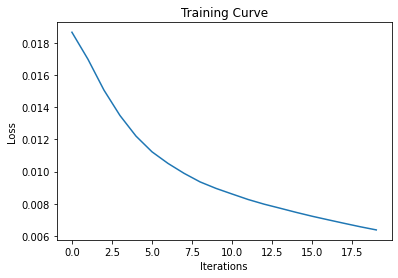

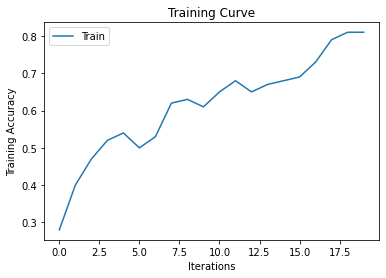

Final Training Accuracy: 0.81
Training time:  0.4589076042175293


In [ ]:
fashon_pre_syn = train_only(trainloader_fashon_pre_syn, get_network('ConvNet', channel_fashon, num_classes_fashon, im_size=im_size_fashon), batch_size=128, num_epochs=20, learning_rate=0.01)

In [ ]:
get_accuracy(fashon_pre_syn, testloader_fashon)

0.7553

##Training with generated synthetic set

In [5]:
fashon_syn_dict = torch.load('/content/drive/MyDrive/ECE1512/ProjectB/All_Code/result/res_DC_FashionMNIST_AlexNet_10ipc.pt')
fashon_syn_data = tf.convert_to_tensor(fashon_syn_dict['data'][0][0])
fashon_syn_label = tf.convert_to_tensor(fashon_syn_dict['data'][0][1])
fashon_syn_data = torch.from_numpy(np.array(fashon_syn_data))
fashon_syn_label = torch.from_numpy(np.array(fashon_syn_label))

fashon_syn_data = (fashon_syn_data - torch.min(fashon_syn_data)) / (torch.max(fashon_syn_data) - torch.min(fashon_syn_data))

trainloader_fashon_syn = torch.utils.data.DataLoader(TensorDataset(fashon_syn_data, fashon_syn_label), batch_size=256, shuffle=True, num_workers=0)

train group tensor(5)


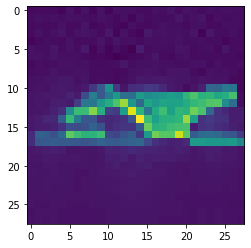

In [14]:
index = random.randint(1, 99)
img=fashon_syn_data[index].reshape(im_size_fashon)
plt.imshow(img)
print('train group',fashon_syn_label[index])

Epoch:  0 ; train acc:  0.34 ; train loss:  2.4160330295562744
Epoch:  1 ; train acc:  0.46 ; train loss:  2.1905980110168457
Epoch:  2 ; train acc:  0.52 ; train loss:  2.0160470008850098
Epoch:  3 ; train acc:  0.66 ; train loss:  1.7971670627593994
Epoch:  4 ; train acc:  0.62 ; train loss:  1.5673984289169312
Epoch:  5 ; train acc:  0.62 ; train loss:  1.4186427593231201
Epoch:  6 ; train acc:  0.73 ; train loss:  1.2830958366394043
Epoch:  7 ; train acc:  0.72 ; train loss:  1.1439197063446045
Epoch:  8 ; train acc:  0.67 ; train loss:  1.0515332221984863
Epoch:  9 ; train acc:  0.71 ; train loss:  0.976719081401825
Epoch:  10 ; train acc:  0.71 ; train loss:  0.8999876976013184
Epoch:  11 ; train acc:  0.72 ; train loss:  0.8425211310386658
Epoch:  12 ; train acc:  0.73 ; train loss:  0.798187792301178
Epoch:  13 ; train acc:  0.75 ; train loss:  0.752632737159729
Epoch:  14 ; train acc:  0.74 ; train loss:  0.7130494117736816
Epoch:  15 ; train acc:  0.74 ; train loss:  0.673822

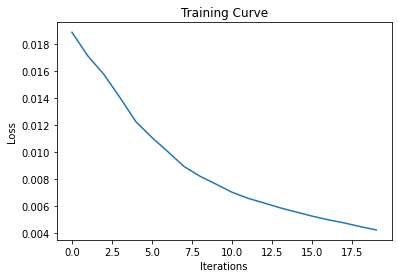

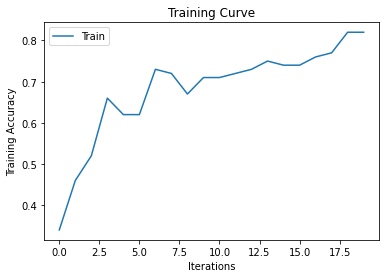

Final Training Accuracy: 0.82
Training time:  0.46180033683776855


In [21]:
fashon_syn = train_only(trainloader_fashon_syn, get_network('ConvNet', channel_fashon, num_classes_fashon, im_size=im_size_fashon), batch_size=128, num_epochs=20, learning_rate=0.01)

In [22]:
get_accuracy(fashon_syn, testloader_fashon)

0.5341

#Result

| Accuracy      | Scratch | Online-Synthetic-set | Self-Synthetic-set |
|---------------|---------|----------------------|--------------------|
| MNIST         | 0.9937  | 0.9211               | 0.9078             |
| Fashion MNIST | 0.9318  | 0.7553               | 0.5341             |

| Training Time/s | Scratch | Online-Synthetic-set | Self-Synthetic-set |
|---------------|---------|----------------------|--------------------|
| MNIST         | 202.30  | 0.46                 | 0.46               |
| Fashion MNIST | 199.68  | 0.46                 | 0.46               |